In [1]:
# Importing essential packages

# Import datetime, for simple date and time storing
import datetime

# Import pandas, for data storage
import pandas as pd

# Import matplotlib.pyplot, for creating plots
import matplotlib.pyplot as plt

# Import numpy, for array manipulation
import numpy as np

# Import the re package
import re

# Import the collections package
import collections


# Install yfinance package
# pip install yfinance

# Import yfinance package as yf
import yfinance as yf

# Import requests
import requests as rq

# Import lxml
import lxml

In [2]:
datetxt_data = pd.read_csv('data_sets_usable/final_datetxt_dataset.csv')

datetxt_data = datetxt_data.drop(labels = 'Unnamed: 0', axis = 1)

datetxt_data['time'] = pd.to_datetime(datetxt_data['time'])



sentiment_data = pd.read_csv('data_sets_usable/final_sentiment_dataset.csv')

sentiment_data = sentiment_data.drop(labels = 'Unnamed: 0', axis = 1)



ticker_data = pd.read_csv('data_sets_usable/final_ticker_dataset.csv')

ticker_data = ticker_data.drop(labels = 'Unnamed: 0', axis = 1)

In [3]:
def append_date_split(dataset, column):

    date_list = dataset[column]

    expanded_date_list = [[date.year, date.month, date.day, date.hour, date.minute, date.second] for date in date_list]

    expanded_date_list = pd.DataFrame(data = expanded_date_list, columns = ['year', 'month', 'day', 'hour', 'minute', 'second'])

    final_date_list = pd.concat(objs = [dataset, expanded_date_list], axis = 1)

    return final_date_list

In [4]:
def append_date_join(dataset, year_column, month_column, day_column, hour_column = None, minute_column = None, second_column = None):

    
    
    dataset = dataset.reset_index().drop(labels = 'index', axis = 1)



    year_column = dataset[year_column]

    month_column = dataset[month_column]

    day_column = dataset[day_column]

    # hour_column = dataset[hour_column]

    # minute_column = dataset[minute_column]

    # second_column = dataset[second_column]



    dataset_length = len(dataset)

    date_set = [datetime.datetime(year = year_column[index], month = month_column[index], day = day_column[index]
    #, hour = hour_column[index], minute = minute_column[index], second = second_column[index]
    ) for index in range(0, dataset_length)]

    date_set = pd.DataFrame(data = date_set, columns = ['time'])

    dataset = pd.concat(objs = [dataset, date_set], axis = 1)

    return dataset

In [5]:
def frequency_prep(ticker_symbol):

    mod_datetxt = datetxt_data.drop(labels = 'text', axis = 1)

    mod_ticker = ticker_data.merge(right = mod_datetxt, how = 'left', on = ['submission', 'comment'])

    mod_ticker = mod_ticker.drop(labels = ['submission', 'comment'], axis = 1)

    baba_ticker = mod_ticker[mod_ticker['ticker'] == ticker_symbol]

    baba_ticker = baba_ticker.sort_values(by = 'time')

    baba_ticker = baba_ticker.reset_index().drop(labels = 'index', axis = 1)

    baba_ticker = append_date_split(baba_ticker, 'time')

    baba_ticker = baba_ticker[['count','month','day']].groupby(by = ['month','day']).sum().reset_index()

    year_column = pd.DataFrame([2021 for i in range(0, len(baba_ticker))], columns = ['year'])

    baba_ticker = pd.concat(objs = [year_column, baba_ticker], axis = 1)

    baba_ticker = append_date_join(baba_ticker, 'year', 'month', 'day')

    return baba_ticker

In [6]:
def sentiment_prep(ticker_symbol):

    mod_datetxt = datetxt_data.drop(labels = 'text', axis = 1)

    mod_ticker = ticker_data.merge(right = mod_datetxt, how = 'left', on = ['submission', 'comment'])

    mod_ticker = mod_ticker.drop(labels = 'count', axis = 1)

    mod_ticker = mod_ticker.merge(right = sentiment_data, how = 'left', on = ['submission', 'comment'])

    mod_ticker = mod_ticker.drop(labels = ['submission', 'comment'], axis = 1)

    mod_ticker = append_date_split(mod_ticker, 'time')

    mod_ticker = mod_ticker[mod_ticker['ticker'] == ticker_symbol]

    mod_ticker = mod_ticker[['neg','neu','pos','month','day','compound']].groupby(by = ['month','day']).sum().reset_index()

    year_column = pd.DataFrame([2021 for i in range(0, len(mod_ticker))], columns = ['year'])

    mod_ticker = pd.concat(objs = [year_column, mod_ticker], axis = 1)

    mod_ticker['month'] = pd.to_numeric(mod_ticker['month'], downcast = 'integer')

    mod_ticker['day'] = pd.to_numeric(mod_ticker['day'], downcast = 'integer')

    mod_ticker = append_date_join(mod_ticker, 'year', 'month', 'day')

    return mod_ticker

In [7]:
ticker_set = ticker_data['ticker']

ticker_set = pd.DataFrame(data = collections.Counter(ticker_set).items(), columns = ['ticker', 'frequency'])

ticker_set = ticker_set.sort_values(by = 'frequency', ascending = False).reset_index().drop(labels = 'index', axis = 1)

ticker_set.iloc[0:10]

ticker_symbol = ticker_set.iloc[0]['ticker']

ticker_symbol

'GME'

In [8]:
ticker_yahoo_connection = yf.Ticker(ticker_symbol)

hist = ticker_yahoo_connection.history(start = '2021-11-21', end = '2021-12-05')

hist = hist.reset_index()

hist['Date'] = pd.to_datetime(hist['Date'])

hist

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-11-22,230.460007,249.639999,229.750000,247.550003,4371400,0,0
1,2021-11-23,243.839996,252.199997,212.559998,213.899994,3345200,0,0
2,2021-11-24,217.250000,223.990005,208.000000,211.779999,1309400,0,0
3,2021-11-26,208.080002,211.729996,199.199997,199.720001,1235300,0,0
4,2021-11-29,204.000000,207.910004,200.940002,202.009995,1108800,0,0
5,2021-11-30,200.100006,203.949997,188.000000,196.210007,1723900,0,0
6,2021-12-01,199.399994,200.110001,177.009995,179.839996,2351500,0,0
7,2021-12-02,185.000000,187.429993,173.070007,181.559998,2087100,0,0
8,2021-12-03,181.000000,183.929993,159.050003,172.389999,4092900,0,0


/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


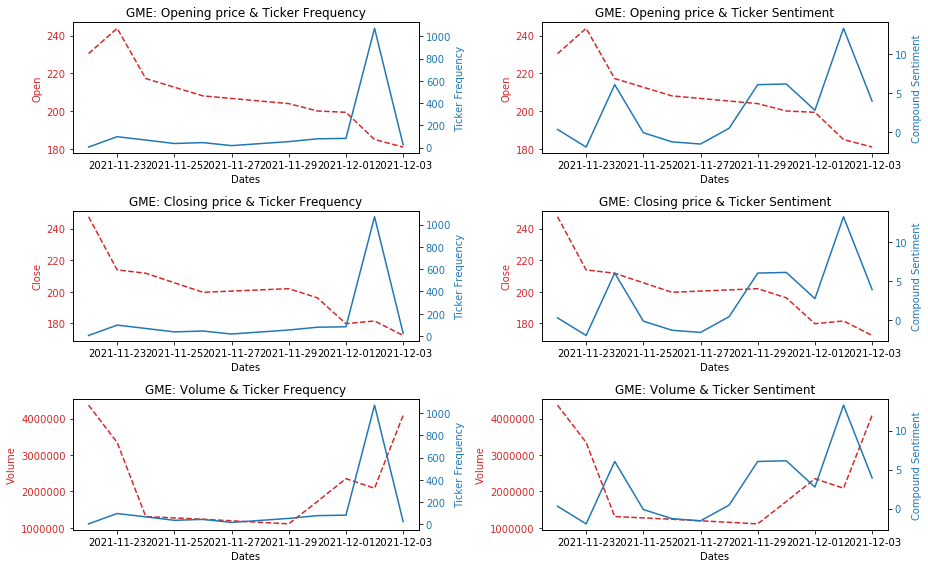

In [9]:
mod_ticker = sentiment_prep(ticker_symbol)

baba_ticker = frequency_prep(ticker_symbol)

fig, ax = plt.subplots(3,2)

fig.set_size_inches(13, 8)

# i axis: Open, Close, Volume

# j axis: Frequency, Sentiment


# For 0, 0 (Open, Frequency)

# First Axis
color = 'tab:red'
ax[0,0].set_xlabel('Dates')
ax[0,0].set_ylabel('Open', color=color)
ax[0,0].plot(hist['Date'], hist['Open'], color=color, linestyle='dashed')
ax[0,0].tick_params(axis='y', labelcolor=color)

# Second Axis
ax1 = ax[0,0].twinx()
color = 'tab:blue'
ax1.set_ylabel('Ticker Frequency', color=color)  # we already handled the x-label with ax1
ax1.plot(baba_ticker['time'], baba_ticker['count'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.title(ticker_symbol+': Opening price & Ticker Frequency')

# For 1, 0 (Close, Frequency)



# First Axis
color = 'tab:red'
ax[1,0].set_xlabel('Dates')
ax[1,0].set_ylabel('Close', color=color)
ax[1,0].plot(hist['Date'], hist['Close'], color=color, linestyle='dashed')
ax[1,0].tick_params(axis='y', labelcolor=color)

# Second Axis
ax2 = ax[1,0].twinx()
color = 'tab:blue'
ax2.set_ylabel('Ticker Frequency', color=color)  # we already handled the x-label with ax1
ax2.plot(baba_ticker['time'], baba_ticker['count'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(ticker_symbol+': Closing price & Ticker Frequency')

# For 2, 0 (Volume, Frequency)

# First Axis
color = 'tab:red'
ax[2,0].set_xlabel('Dates')
ax[2,0].set_ylabel('Volume', color=color)
ax[2,0].plot(hist['Date'], hist['Volume'], color=color, linestyle='dashed')
ax[2,0].tick_params(axis='y', labelcolor=color)

# Second Axis
ax3 = ax[2,0].twinx()
color = 'tab:blue'
ax3.set_ylabel('Ticker Frequency', color=color)  # we already handled the x-label with ax1
ax3.plot(baba_ticker['time'], baba_ticker['count'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

plt.title(ticker_symbol+': Volume & Ticker Frequency')

# For 0, 1 (Open, Compound)

# First Axis
color = 'tab:red'
ax[0,1].set_xlabel('Dates')
ax[0,1].set_ylabel('Open', color=color)
ax[0,1].plot(hist['Date'], hist['Open'], color=color, linestyle='dashed')
ax[0,1].tick_params(axis='y', labelcolor=color)

# Second Axis
ax4 = ax[0,1].twinx()
color = 'tab:blue'
ax4.set_ylabel('Compound Sentiment', color=color)  # we already handled the x-label with ax1
ax4.plot(mod_ticker['time'], mod_ticker['compound'], color=color)
ax4.tick_params(axis='y', labelcolor=color)

plt.title(ticker_symbol+': Opening price & Ticker Sentiment')

# First Axis
color = 'tab:red'
ax[1,1].set_xlabel('Dates')
ax[1,1].set_ylabel('Close', color=color)
ax[1,1].plot(hist['Date'], hist['Close'], color=color, linestyle='dashed')
ax[1,1].tick_params(axis='y', labelcolor=color)

# Second Axis
ax5 = ax[1,1].twinx()
color = 'tab:blue'
ax5.set_ylabel('Compound Sentiment', color=color)  # we already handled the x-label with ax1
ax5.plot(mod_ticker['time'], mod_ticker['compound'], color=color)
ax5.tick_params(axis='y', labelcolor=color)

plt.title(ticker_symbol+': Closing price & Ticker Sentiment')

# First Axis
color = 'tab:red'
ax[2,1].set_xlabel('Dates')
ax[2,1].set_ylabel('Volume', color=color)
ax[2,1].plot(hist['Date'], hist['Volume'], color=color, linestyle='dashed')
ax[2,1].tick_params(axis='y', labelcolor=color)

# Second Axis
ax6 = ax[2,1].twinx()
color = 'tab:blue'
ax6.set_ylabel('Compound Sentiment', color=color)  # we already handled the x-label with ax1
ax6.plot(mod_ticker['time'], mod_ticker['compound'], color=color)
ax6.tick_params(axis='y', labelcolor=color)

plt.title(ticker_symbol+': Volume & Ticker Sentiment')

fig.tight_layout()

plt.show()